<a href="https://colab.research.google.com/github/kaanbaycan/IE-423-Forecasting-Tasks/blob/main/IE_423_Task_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Import and Inital Functions

In [1]:
from google.colab import files
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

In [2]:
def upload_dataset(from_drive = False):
  if not os.path.exists("kaggle.json"):
    if not from_drive:
      print("Upload Kaggle API Key")
      files.upload()
      print("Downloading dataset...")
    else:
      !cp /content/drive/MyDrive/kaggle.json /content/
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    !kaggle datasets download -d prepinstaprime/black-friday-sales-data
    !unzip black-friday-sales-data.zip
  else:
    print("Dataset already exists")

In [3]:
upload_dataset()

Dataset already exists


In [4]:
#We start with basic statistics for both numeric and categorical data
def unistats(dataframe,sorted="Missing"):
    """"
    Takes dataframe and sorted as parameter
    Returns count, missing, unique, dtype, mode and other stats"""
    pd.set_option("display.max_rows",100)
    pd.set_option("display.max_columns",100)
    output_df = pd.DataFrame(columns = ["Count","Missing","Unique", "Dtype", "Mode", "Mean", "Min", "25%", "Median", "75%", "Max", "Std", "Skew", "Kurt"])

    for col in dataframe:
        if pd.api.types.is_numeric_dtype(dataframe[col]):
            output_df.loc[col] =[dataframe[col].count() ,dataframe[col].isnull().sum() ,dataframe[col].nunique() ,dataframe[col].dtype ,dataframe[col].mode().values[0], dataframe[col].mean(), dataframe[col].min(), dataframe[col].quantile(0.25), dataframe[col].median(), dataframe[col].quantile(0.75),dataframe[col].max(), dataframe[col].std(), dataframe[col].skew(),dataframe[col].kurt()]
        else:
            output_df.loc[col] =[dataframe[col].count() ,dataframe[col].isnull().sum() ,dataframe[col].nunique() ,dataframe[col].dtype , "-", "-", "-","-", "-", "-","-", "-", "-","-"]


    return output_df.sort_values(by = ["Dtype",sorted])

In [5]:
#Lets make an anova test to see if this much category is needed
def barplots(dataframe, label, target):
    from scipy import stats
    """
    Takes dataframe, feature and target as parameter
    Applies t-tests for categorical features
    Returns a barpot with t-stat and p values"""
    ttests = []
    string = "Categories  t stat  p value \n "
    if pd.api.types.is_numeric_dtype(dataframe[label]) == False and len(dataframe[label].unique()) <= 20 and len(dataframe[label].unique())>=2:
        e_types = dataframe[label].unique()
        for i, e in enumerate(e_types):
            for i2, e2 in enumerate(e_types):
                if i2 >= i :
                    g1 = dataframe[dataframe[label] == e][target]
                    g2 = dataframe[dataframe[label] == e2][target]
                    t, p = stats.ttest_ind(g1,g2)
                    ttests.append([f"{e} - {e2}", t, p])
                    string += (f"{e} - {e2}: {t:.4f}, {p:.5f} " + " \n ")
                    if p < 0.05:
                        string += "Significant" + "\n"
                    else:
                        string += "Not Significant" + "\n"
        plt.figure()
        plt.figsize=(10,6)
        plt.text(5, 0.1, string, fontsize = 8)
        viz = sns.barplot(data = dataframe, x = label , y = target,)
        viz.set_xticklabels(viz.get_xticklabels(), rotation = 90)
        viz.set(title = f"{target} by {label}")
        plt.show()

In [6]:
#To start visualizing data, lets first see the best features in terms of explainin the variance of target
def correlation(dataframe, target):
    from scipy import stats
    """
    Takes dataframe and target feature as parameter
    Returns the correlation between numeric columns and target"""

    output_dataframe = pd.DataFrame(columns = ["Columns","P-Value","Correlation Coefficient(r)","Absolute r"])
    for col in dataframe.drop(target,axis = 1):
        try:
            if pd.api.types.is_numeric_dtype(dataframe[col]):
                r, p = stats.pearsonr(dataframe[col],dataframe[target])
                output_dataframe.loc[col] = [f"{target}-{col}",round(p,4),r,abs(r)]
            else:
                pass
        except:
            pass

    return output_dataframe.sort_values(by = ["Absolute r"],ascending = False)

In [7]:
def hist_and_boxplot(dataframe, label):
    """
    Takes dataframe and feature as parameter
    Returns histogram and boxplot"""
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    sns.histplot(data = dataframe, x = label)
    plt.subplot(1,2,2)
    sns.boxplot(data = dataframe, x = label)
    plt.show();

In [8]:
def categorical_pie(dataframe, label):
    """
    Takes dataframe and feature as parameter
    Returns pie chart along with value counts"""
    plt.figure(figsize=(10,6))
    plt.subplot(1,2,1)
    dataframe[label].value_counts().plot.pie(autopct = "%1.1f%%")
    plt.subplot(1,2,2)
    sns.countplot(data = dataframe, x = label)

In [9]:
def scatter(dataframe, target, feature):
    from statsmodels.formula.api import ols
    from statsmodels.stats.diagnostic import het_breuschpagan
    from scipy import stats
    """
    Takes dataframe, target and feature as parameter
    Use it with a numeric column
    Fits an OLS model with the given feature
    Applies breuschpagan test
    Returns the scatterplot, regression and test results.
    """

    sns.set_style(style="white")

    model = ols(formula= f"{target}~{feature}", data = dataframe).fit()

    lm, p1, f, p2 = het_breuschpagan(model.resid,model.model.exog)
    m, b, r, p, err = stats.linregress(dataframe[feature], dataframe[target])

    string = "y = " + str(round(m,2)) + "x " + str(round(b,2)) + "\n"
    string += "r_2 = " + str(round(r**2, 4))  + "\n"
    string += str(round(r**2, 4)*100) + "% of variance is explained" + "\n"
    string += "p = " + str(round(p, 5)) + "\n"
    if p < 0.05:
        string += "Significant" + "\n"
    else:
        string += "Not Significant" + "\n"
    string += str(dataframe[feature].name) + " skew = " + str(round(dataframe[feature].skew(), 2)) + "\n"
    if dataframe[feature].skew() < 0:
        string += str(dataframe[feature].name) + " is negatively skewed" + "\n"
    else:
        string += str(dataframe[feature].name) + " is positively skewed" + "\n"
    string += str(dataframe[target].name) + " skew = " + str(round(dataframe[target].skew(), 2)) + "\n"
    if dataframe[target].skew() < 0:
        string += str(dataframe[target].name) + " is negatively skewed" + "\n"
    else:
        string += str(dataframe[target].name) + " is positively skewed" + "\n"
    string += str(dataframe[feature].name) + " Breushpagan Test = " + "LM stat: " + str(round(lm,4)) + " p value: " + str(round(p1,4)) + " F stat: " + str(round(f,4)) + " p value: " + str(round(p2,4)) + "\n"
    if p1 < 0.05:
        string += "Variance of residuals are not distributed equally" + "\n"
    else:
        string += "Variance of residuals are distributed equally" + "\n"
    ax = sns.jointplot(x = feature, y = target, kind = "reg", data = dataframe)
    ax.fig.text( 1, 0.1, string, fontsize = 12, transform = plt.gcf().transFigure)


# EDA

In [10]:
df = pd.read_csv("train.csv")

In [11]:
df.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
0,1000001,P00069042,F,0-17,10,A,2,0,3,NaN,NaN,8370
1,1000001,P00248942,F,0-17,10,A,2,0,1,6.0,14.0,15200
2,1000001,P00087842,F,0-17,10,A,2,0,12,NaN,NaN,1422
3,1000001,P00085442,F,0-17,10,A,2,0,12,14.0,NaN,1057
4,1000002,P00285442,M,55+,16,C,4+,0,8,NaN,NaN,7969


In [12]:
# Our aim is to segment customers, hence id based dataframe will be useful
users_df = pd.DataFrame(columns=["User_ID", "Gender", "Age", "Occupation", "City_Category", "Stay_In_Current_City_Years", "Marital_Status", "Total_Purchase"])

In [13]:
users_df = df.groupby("User_ID").agg({"Gender":"first", "Age":"first", "Occupation":"first", "City_Category":"first", "Stay_In_Current_City_Years":"first", "Marital_Status":"first", "Purchase":"sum"})

In [14]:
users_df.head()

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Purchase
User_ID,,,,,,,
1000001,F,0-17,10,A,2,0,334093
1000002,M,55+,16,C,4+,0,810472
1000003,M,26-35,15,A,3,0,341635
1000004,M,46-50,7,B,2,1,206468
1000005,M,26-35,20,A,1,1,821001


In [15]:
#Lets add 2 more features: Average Purchase Amount, Total Count of Purchases
users_df["Total_Purchase_Count"] = df.groupby("User_ID").agg({"Purchase":"count"})
users_df["Average_Purchase_Amount"] = df.groupby("User_ID").agg({"Purchase":"mean"})

In [16]:
users_df

,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Purchase,Total_Purchase_Count,Average_Purchase_Amount
User_ID,,,,,,,,,
1000001,F,0-17,10,A,2,0,334093,35,9545.514286
1000002,M,55+,16,C,4+,0,810472,77,10525.610390
1000003,M,26-35,15,A,3,0,341635,29,11780.517241
1000004,M,46-50,7,B,2,1,206468,14,14747.714286
1000005,M,26-35,20,A,1,1,821001,106,7745.292453
...,...,...,...,...,...,...,...,...,...
1006036,F,26-35,15,B,4+,1,4116058,514,8007.894942
1006037,F,46-50,1,C,4+,0,1119538,122,9176.540984
1006038,F,55+,1,C,2,0,90034,12,7502.833333


In [17]:
unistats(users_df)

,Count,Missing,Unique,Dtype,Mode,Mean,Min,25%,Median,75%,Max,Std,Skew,Kurt
Occupation,5891,0,21,int64,4,8.153285,0,3.0,7.0,14.0,20,6.32314,0.33749,-1.212475
Marital_Status,5891,0,2,int64,0,0.419963,0,0.0,0.0,1.0,1,0.493594,0.324414,-1.895399
Purchase,5891,0,5876,int64,116586,865016.59175,46681,237678.0,521213.0,1119249.5,10536909,943644.539683,2.427964,8.538912
Total_Purchase_Count,5891,0,482,int64,15,93.3743,6,26.0,54.0,117.0,1026,107.190049,2.600637,9.164084
Average_Purchase_Amount,5891,0,5886,float64,7992.153846,9568.839914,2318.733333,8287.212366,9386.208333,10654.633199,18577.893617,1890.087105,0.54966,0.88902
Gender,5891,0,2,object,-,-,-,-,-,-,-,-,-,-
Age,5891,0,7,object,-,-,-,-,-,-,-,-,-,-
City_Category,5891,0,3,object,-,-,-,-,-,-,-,-,-,-
Stay_In_Current_City_Years,5891,0,5,object,-,-,-,-,-,-,-,-,-,-


* We have 5891 users
* Average purchase by user is app 10k
* Average purchase by customer is 93

## Occupation

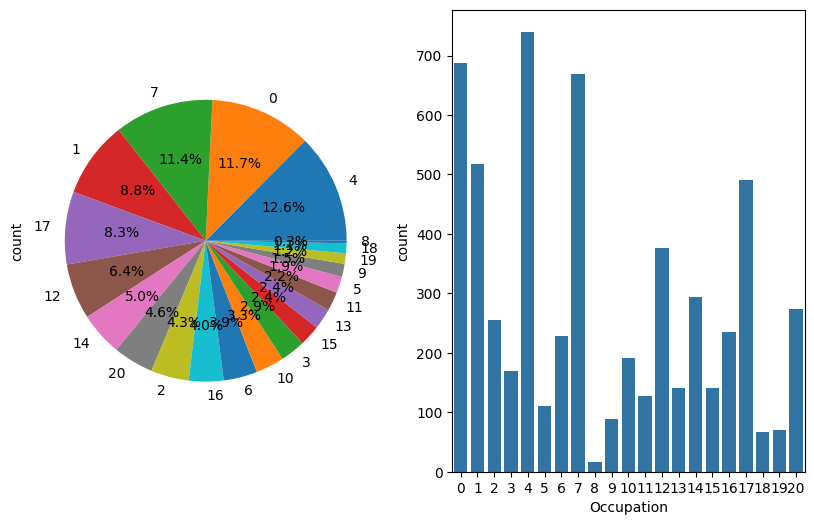

In [18]:
categorical_pie(users_df, "Occupation")

* We have 20 different professions among users
* Very imbalanced portion of professions --> We may group some together based on other features
* 4,0,7 has the mostly used occupations

<Axes: xlabel='Occupation', ylabel='Purchase'>

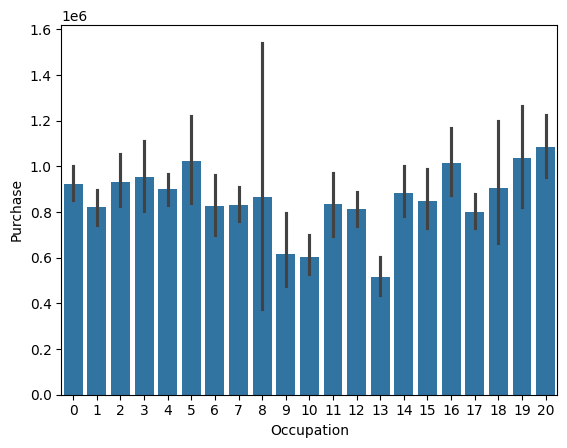

In [19]:
# Lets look at the most purchasing occupations
sns.barplot(data = users_df, x = "Occupation", y = "Purchase")

I do not see much difference between total purchases by occupation.

<Axes: xlabel='Occupation', ylabel='Total_Purchase_Count'>

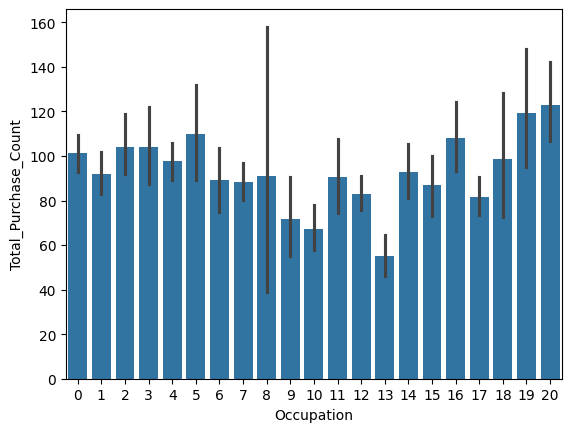

In [20]:
#Lets look at the occupation vs count of purchases
sns.barplot(data = users_df, x = "Occupation", y = "Total_Purchase_Count")

Similar to above table.

## Marital Status

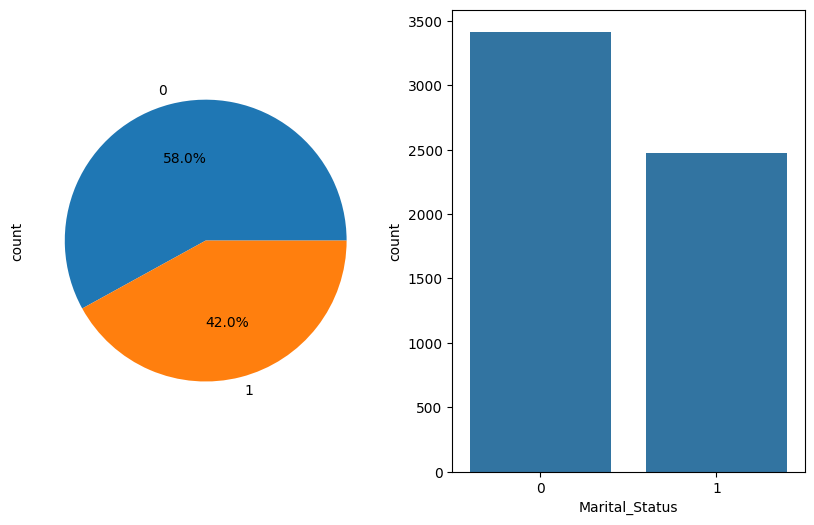

In [21]:
categorical_pie(users_df, "Marital_Status")

* 58% of our users are unmarried

<Axes: xlabel='Marital_Status', ylabel='Purchase'>

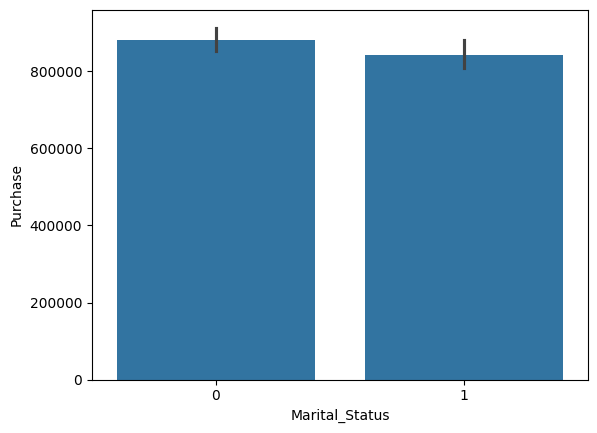

In [22]:
# Lets look at marital status with total purchases and count
sns.barplot(data = users_df, x = "Marital_Status", y = "Purchase")

## Gender

<Axes: title={'center': 'Gender vs Purchase'}, xlabel='Gender', ylabel='Purchase'>

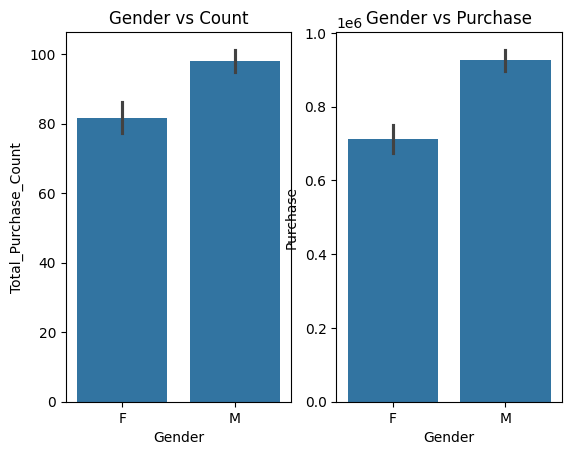

In [23]:
#Lets look at who purchase more
plt.subplot(1,2,1)
plt.title("Gender vs Count")
plt.figsize=(10,6)
sns.barplot(data = users_df, x = "Gender", y = "Total_Purchase_Count")
plt.subplot(1,2,2)
plt.figsize=(10,6)
plt.title("Gender vs Purchase")
sns.barplot(data = users_df, x = "Gender", y = "Purchase")

* Males tend to purhcase more in terms of both value and count. Hence we do not even have to look at the average.

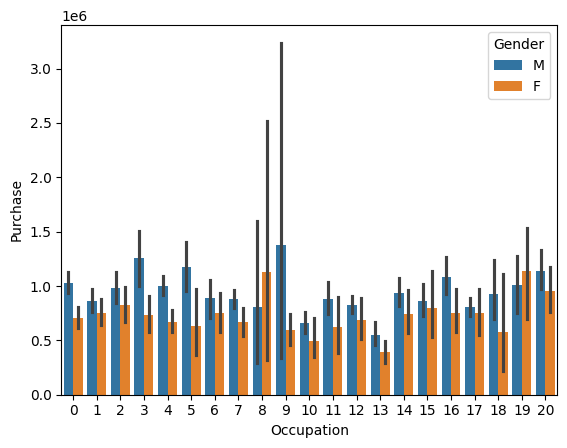

In [24]:
#Lets look at occupation by gender
sns.barplot(data = users_df, x = "Occupation", y = "Purchase", hue = "Gender");

* Females only has more at 8th occupation.

## Age

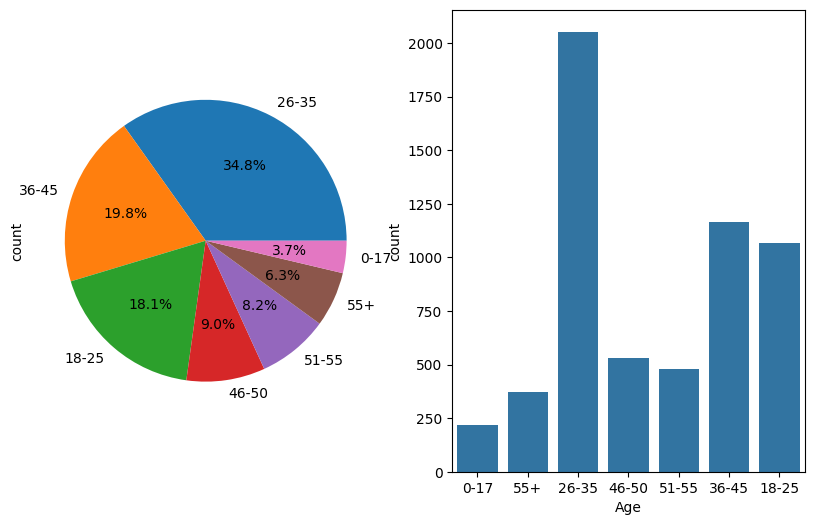

In [25]:
categorical_pie(users_df, "Age")

* Teen tend to purchase more

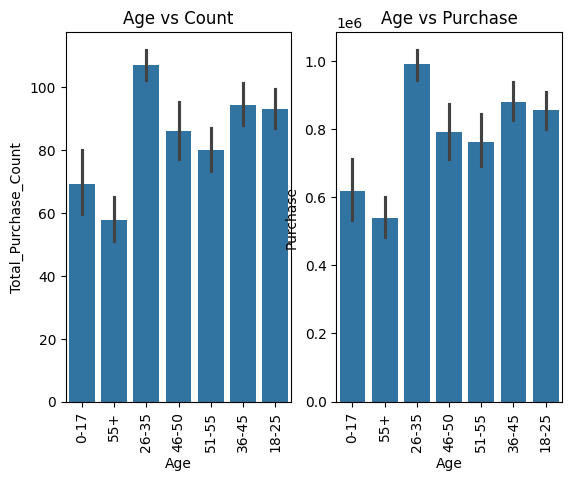

In [26]:
#Lets look at by the total amount purchase and count
plt.subplot(1,2,1)
plt.title("Age vs Count")
plt.figsize=(10,6)
plt.xticks(rotation = 90)
sns.barplot(data = users_df, x = "Age", y = "Total_Purchase_Count")
plt.subplot(1,2,2)
plt.figsize=(10,6)
plt.xticks(rotation = 90)
plt.title("Age vs Purchase")
sns.barplot(data = users_df, x = "Age", y = "Purchase");

* Although 26-35 has much more customers, purchase amounts of other categories almost reach to 26-35 bar.

## City Category

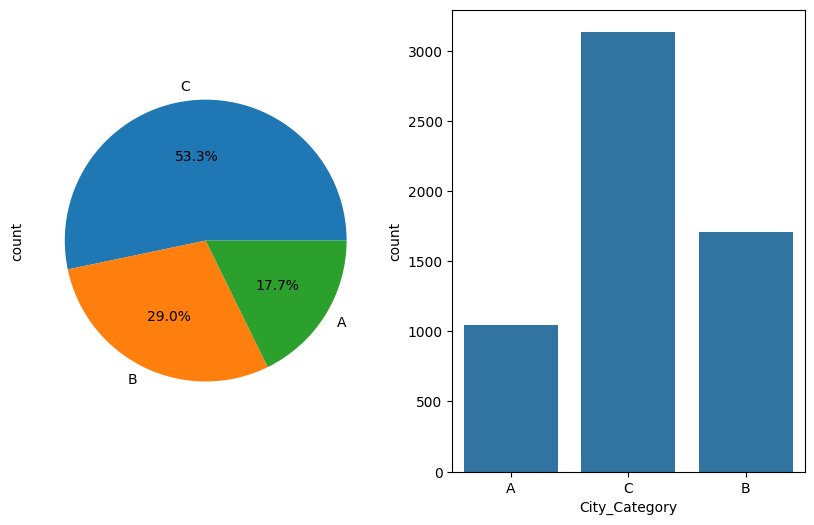

In [27]:
categorical_pie(users_df, "City_Category")

<Axes: title={'center': 'City Category vs Count'}, xlabel='City_Category', ylabel='Total_Purchase_Count'>

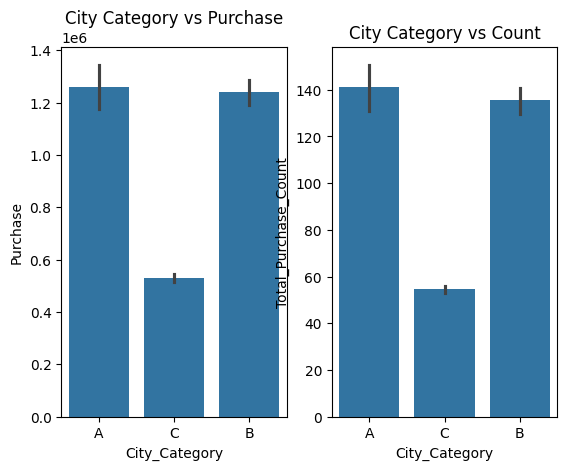

In [28]:
# Category of city ve purchase, and count
plt.subplot(1,2,1)
plt.title("City Category vs Purchase")
plt.figsize=(10,6)
sns.barplot(data = users_df, x = "City_Category", y = "Purchase")
plt.subplot(1,2,2)
plt.title("City Category vs Count")
plt.figsize=(10,6)
sns.barplot(data = users_df, x = "City_Category", y = "Total_Purchase_Count")


Although we have more people from C city, purchase amount show that A and B spends more.

# Preprocessig

In [30]:
# One hot encode the categorical columns
numeric_features = ["Purchase","Total_Purchase_Count"]
categorical_features = ["Gender","Age","Occupation","City_Category","Stay_In_Current_City_Years","Marital_Status"]
one_hot_df = pd.get_dummies(users_df[categorical_features], columns = categorical_features, dtype = int, drop_first = True)
one_hot_df = pd.concat([users_df[numeric_features], one_hot_df], axis = 1)

# Clustering

<Axes: xlabel='Average_Purchase_Amount', ylabel='Total_Purchase_Count'>

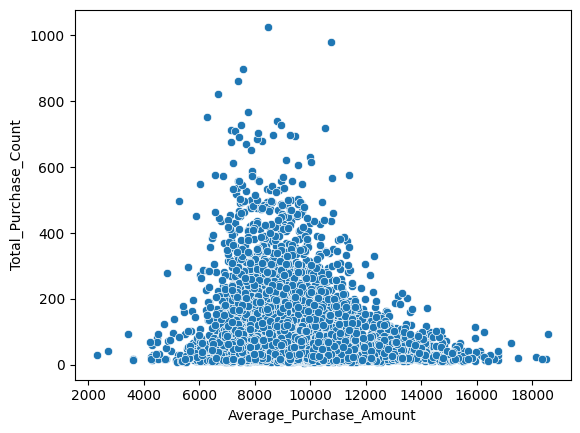

In [31]:
sns.scatterplot(data = users_df, x = "Average_Purchase_Amount", y = "Total_Purchase_Count")

## KMeans

In [32]:
from sklearn.cluster import KMeans

In [33]:
cluster = KMeans(n_clusters = 3, n_init=10)
cluster.fit(users_df[["Total_Purchase_Count","Average_Purchase_Amount"]])

KMeans(n_clusters=3, n_init=10)

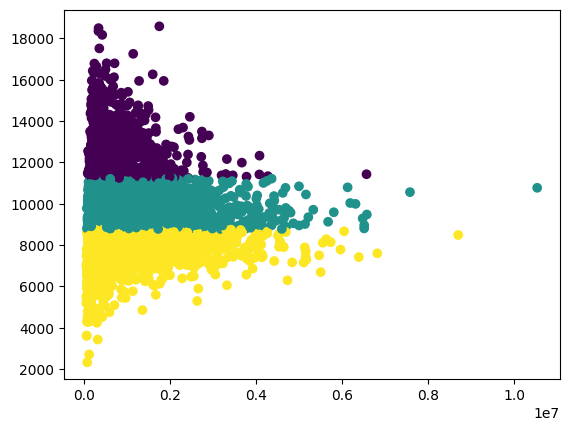

In [34]:
plt.scatter(users_df["Purchase"], users_df["Average_Purchase_Amount"], c = cluster.labels_)

In [35]:
#Lets calculate silhoutte score
from sklearn.metrics import silhouette_score

In [36]:
silhouette_score(users_df[["Total_Purchase_Count","Average_Purchase_Amount"]], cluster.labels_)

0.5192784943589026

In [37]:
for i in range(2,5):
    cluster = KMeans(n_clusters = i,n_init = 10)
    cluster.fit(users_df[["Total_Purchase_Count","Average_Purchase_Amount"]])
    print(f'Silhouette score for {i} clusters: {silhouette_score(users_df[["Total_Purchase_Count","Average_Purchase_Amount"]], cluster.labels_)}')

Silhouette score for 2 clusters: 0.5448400842274179
Silhouette score for 3 clusters: 0.5193007033607643
Silhouette score for 4 clusters: 0.5139425256768535


As we can see above, silhoutte scores are pretty low ,i.e, the max we got is 0.54. Hence, lets focus on some other columns..

In [38]:
all = KMeans(n_clusters=2, n_init=10)
all.fit(one_hot_df)

KMeans(n_clusters=2, n_init=10)

In [39]:
silhouette_score(one_hot_df, all.labels_)

0.7241210801148166

In [40]:
for i in range(2,5):
    cluster = KMeans(n_clusters = i,n_init=10)
    cluster.fit(one_hot_df)
    print(f'Silhouette score for {i} clusters: {silhouette_score(one_hot_df, cluster.labels_)}')

Silhouette score for 2 clusters: 0.7241210801148166
Silhouette score for 3 clusters: 0.6725142559074152
Silhouette score for 4 clusters: 0.6328314227919625


Fitting all of the columns resulted in a much better solution with silhoutte score 0.72

In [41]:
one_hot_df.head()

,Purchase,Total_Purchase_Count,Gender_M,Age_18-25,Age_26-35,Age_36-45,Age_46-50,Age_51-55,Age_55+,Occupation_1,Occupation_2,Occupation_3,Occupation_4,Occupation_5,Occupation_6,Occupation_7,Occupation_8,Occupation_9,Occupation_10,Occupation_11,Occupation_12,Occupation_13,Occupation_14,Occupation_15,Occupation_16,Occupation_17,Occupation_18,Occupation_19,Occupation_20,City_Category_B,City_Category_C,Stay_In_Current_City_Years_1,Stay_In_Current_City_Years_2,Stay_In_Current_City_Years_3,Stay_In_Current_City_Years_4+,Marital_Status_1
User_ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1000001,334093,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1000002,810472,77,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0
1000003,341635,29,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0
1000004,206468,14,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1
1000005,821001,106,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1


In [42]:
#Lets get rid occupation related features
one_hot_df = one_hot_df.drop(["Occupation_20","Occupation_1","Occupation_2","Occupation_3","Occupation_4","Occupation_5","Occupation_6","Occupation_7","Occupation_8","Occupation_9","Occupation_10","Occupation_11","Occupation_12","Occupation_13","Occupation_14","Occupation_15","Occupation_16","Occupation_17","Occupation_18","Occupation_19"],axis = 1)

In [43]:
all_but_occupation = KMeans(n_clusters=2, n_init=10)
all_but_occupation.fit(one_hot_df)

KMeans(n_clusters=2, n_init=10)

In [44]:
print(silhouette_score(one_hot_df, all_but_occupation.labels_))

0.7241210801229598


Nothing much changed??

In [45]:
#Lets only use numerical columns
knn_numeric = KMeans(n_clusters=2, n_init=10)
knn_numeric.fit(users_df[numeric_features])

KMeans(n_clusters=2, n_init=10)

In [46]:
print(silhouette_score(users_df[numeric_features], knn_numeric.labels_))

0.7241210801452758


It seems like only numerical columns are necessary to obtain the best s.s.

## Hierarchical Clustering

In [49]:
#Lets do hierachial clustering
from scipy.cluster import hierarchy

In [50]:
model = hierarchy.linkage(users_df[numeric_features], method = "ward")

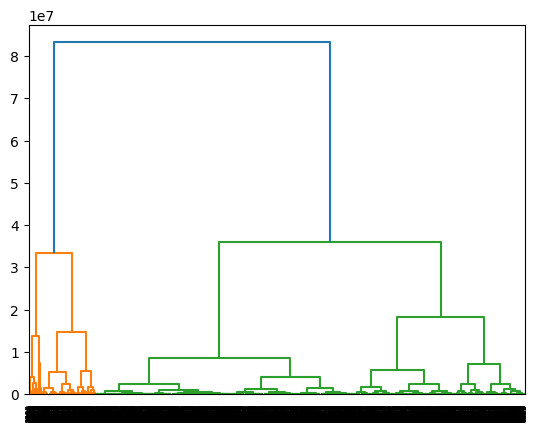

In [52]:
hierarchy.dendrogram(model)
plt.show()

In [51]:
silhouette_score(users_df[numeric_features], hierarchy.fcluster(model, 2, criterion = "maxclust"))

0.7306070207159416

In [53]:
#Lets also try with all feautures
all_hier = hierarchy.linkage(one_hot_df, method = "ward")
print(silhouette_score(one_hot_df, hierarchy.fcluster(all_hier, 2, criterion = "maxclust")))

0.7306070206958897


## Aggleromerative Clustering

In [54]:
#Lets also do aggleromerative clustering
from sklearn.cluster import AgglomerativeClustering

In [55]:
model2 = AgglomerativeClustering(n_clusters = 3)
model2.fit(users_df[numeric_features])

AgglomerativeClustering(n_clusters=3)

In [56]:
silhouette_score(users_df[numeric_features], model2.labels_)

0.5863842162492634

In [58]:
for i in range(2,5):
    model2 = AgglomerativeClustering(n_clusters = i)
    model2.fit(users_df[numeric_features])
    print(f'Silhouette score for {i} clusters: {silhouette_score(users_df[numeric_features], model2.labels_)}')

Silhouette score for 2 clusters: 0.7306070207159416
Silhouette score for 3 clusters: 0.5863842162492634
Silhouette score for 4 clusters: 0.5985545536893785
